In [1]:
from    typing              import  *
from    typing_extensions   import  Self

from    tqdm.notebook       import  tqdm

import  numpy               as  np
import  matplotlib.pyplot   as  plt

import  torch
from    torch.utils.data    import  Dataset, DataLoader


from    pathlib             import  Path
root_dir    = r"/media/junseung/47a90e46-3a9d-467c-bbee-066752b68532/GWANGJAE"
path_root   = Path(root_dir)
path_lib    = path_root / "python_deep_numerical"
path_data   = path_root / "datasets_short" / "Boltzmann_2D" / "various" / "coeff1.59e-01"

import  sys
sys.path.append( str(path_lib) )
from    pytorch.layers  import  FourierBoltzmannLayer
from    pytorch         import  utils
from    pytorch.utils   import  initialize_weights


dtype               = torch.float32
dtype_complex       = utils.dtype_real_to_complex(dtype)
device              = torch.device('cuda:2')
dtype_and_device    = {'dtype': dtype, 'device': device}
print(f"Device for computation\n>>> {device}")

Device for computation
>>> cuda:2


In [2]:
DIMENSION:  int     = 2
RESOLUTION: int     = 64
VHS_ALPHA:  float   = 0.0

_file = path_data / "res064__alpha0.0e+00__part1.pth"
_file = r"/media/junseung/47a90e46-3a9d-467c-bbee-066752b68532/GWANGJAE/datasets_short/Boltzmann_2D/various/coeff1.59e-01/res064__alpha0.0e+00__part01.pth"
file = torch.load(_file, weights_only=False)

V_MAX:      float   = float(file['v_max'])
DELTA_V:    float   = (2*V_MAX) / RESOLUTION
FFT_NORM:   str     = 'forward'

VHS_COEFF:  float   = file['vhs_coeff']

In [3]:
class CustomDataset(Dataset):
    def __init__(
            self,
            distr:      torch.Tensor,
            q_gain:     torch.Tensor,
            q_loss:     torch.Tensor,
            vhs_alpha:  Optional[torch.Tensor]  = None,
            dim:        Optional[int]           = None,
            squeeze_space: bool = False,
        ) -> Self:
        self.dim:       int                         = dim
        self.distr:     torch.Tensor                = distr
        self.q_gain:    torch.Tensor                = q_gain
        self.q_loss:    torch.Tensor                = q_loss
        self.vhs_alpha: Optional[torch.Tensor]      = vhs_alpha
        self.__fft_dim: tuple[int] = tuple(range(1+dim, 1+2*dim))
        
        if squeeze_space:
            self.distr      = self.distr.reshape(-1, *distr.shape[-1-dim:])
            self.q_gain   = self.q_gain.reshape(-1, *q_gain.shape[-1-dim:])
            self.q_loss   = self.q_loss.reshape(-1, *q_loss.shape[-1-dim:])
            self.__fft_dim  = tuple(range(1, 1+dim))
            
        return
    
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor]:
        if self.vhs_alpha:
            return self.distr[index], self.q_gain[index], self.q_loss[index], self.vhs_alpha[index]
        else:
            return self.distr[index], self.q_gain[index], self.q_loss[index]
    
    def __len__(self) -> int:
        return self.distr.size(0)
    
    
    @property
    def fft_dim(self) -> tuple[int]:
        return self.__fft_dim

In [4]:
dataset  = CustomDataset(
    file['input_distribution'].reshape(-1, 1, 1, RESOLUTION, RESOLUTION, 1),
    file['collision_gain'].reshape(-1, 1, 1, RESOLUTION, RESOLUTION, 1) / VHS_COEFF,
    file['collision_loss'].reshape(-1, 1, 1, RESOLUTION, RESOLUTION, 1) / VHS_COEFF,
    dim=DIMENSION,
    squeeze_space=False,
)
dataloader  = DataLoader(dataset, batch_size=256, shuffle=True)
FFT_DIM = dataset.fft_dim
print(FFT_DIM)

(3, 4)


In [5]:
specnet     = FourierBoltzmannLayer(DIMENSION, 8, n_channels=1, n_weights=2).to(device)
initialize_weights(specnet, 'xavier normal')
optimizer   = torch.optim.Adam(specnet.parameters(), lr=1e-2)

print(specnet)

==============================< FourierBoltzmannLayer >==============================
[ Subnetworks ]

-------------------------------------------------------------------------------------
[ Parameters ]
( params_alpha )
- Shape:       [16, 16, 1, 2]
- Data type:   torch.complex64
( params_beta )
- Shape:       [16, 16, 1, 2]
- Data type:   torch.complex64
( params_gamma )
- Shape:       [16, 16, 1, 2]
- Data type:   torch.complex64
( params_diag )
- Shape:       [16, 16, 1]
- Data type:   torch.complex64
-------------------------------------------------------------------------------------
Number of parameters: 3584


In [6]:
# test_q_gain = specnet.compute_gain_fft(dataset[[0]][0])
dataset[:10][0].shape

torch.Size([10, 1, 1, 64, 64, 1])

In [7]:
NUM_EPOCHS: int = 10000
dv = DELTA_V**DIMENSION
specnet.train()

data:   torch.Tensor
q_gain: torch.Tensor
q_loss: torch.Tensor

for epoch in tqdm(range(1, 1+NUM_EPOCHS)):
    rel_error_g:    float = 0.0
    rel_error_l:    float = 0.0    
    rel_error_q:    float = 0.0
    for data, q_gain, q_loss in dataloader:
        data    = data.to(device)
        q_gain  = q_gain.to(device)
        q_loss  = q_loss.to(device)
        data_fft:   torch.Tensor = torch.fft.fftn(data, dim=FFT_DIM, norm=FFT_NORM)
        
        pred_gain_fft:  torch.Tensor = specnet.compute_gain_fft(data_fft)
        pred_loss_fft:  torch.Tensor = specnet.compute_loss_fft(data_fft)
        pred_gain:    torch.Tensor = torch.fft.ifftn(pred_gain_fft, dim=FFT_DIM, norm=FFT_NORM).real
        pred_loss:    torch.Tensor = torch.fft.ifftn(pred_loss_fft, dim=FFT_DIM, norm=FFT_NORM).real

        _rel_error_g = utils.relative_error(pred_gain, q_gain).sum()
        _rel_error_l = utils.relative_error(pred_loss, q_loss).sum()
        _rel_error_q = utils.relative_error(pred_gain-pred_loss, q_gain-q_loss).sum()
        rel_error_g += _rel_error_g.item()
        rel_error_l += _rel_error_l.item()
        rel_error_q += _rel_error_q.item()
        loss_tensor = _rel_error_g + _rel_error_l
        
        optimizer.zero_grad()
        loss_tensor.backward()
        optimizer.step()
        
    rel_error_g /= len(dataset)
    rel_error_l /= len(dataset)
    rel_error_q /= len(dataset)
    if epoch%10==0 or epoch==1:
        print(f"[ Epoch {str(epoch).zfill(len(str(NUM_EPOCHS)))} ]")
        print(f"* Relative error (gain):        {rel_error_g:.4e}")
        print(f"* Relative error (loss):        {rel_error_l:.4e}")
        print(f"* Relative error (collision):   {rel_error_q:.4e}")
        print('-'*50)

specnet.eval()

  0%|          | 0/10000 [00:00<?, ?it/s]

[ Epoch 00001 ]
* Relative error (gain):        9.9996e-01
* Relative error (loss):        9.9860e-01
* Relative error (collision):   8.3640e+02
--------------------------------------------------
[ Epoch 00010 ]
* Relative error (gain):        7.1736e-01
* Relative error (loss):        9.7544e-01
* Relative error (collision):   1.5697e+05
--------------------------------------------------
[ Epoch 00020 ]
* Relative error (gain):        1.5991e-01
* Relative error (loss):        9.4986e-01
* Relative error (collision):   4.7160e+05
--------------------------------------------------
[ Epoch 00030 ]
* Relative error (gain):        4.9774e-02
* Relative error (loss):        9.2446e-01
* Relative error (collision):   4.3531e+05
--------------------------------------------------
[ Epoch 00040 ]
* Relative error (gain):        3.4625e-02
* Relative error (loss):        8.9927e-01
* Relative error (collision):   4.1899e+05
--------------------------------------------------
[ Epoch 00050 ]
* Re

FourierBoltzmannLayer()

In [23]:
arr_f, arr_gain, arr_loss = dataset[:]
arr_q = (arr_gain - arr_loss).to(device)
pred = specnet.forward(torch.fft.fftn(arr_f.to(device), dim=FFT_DIM, norm=FFT_NORM))
pred = torch.fft.ifftn(pred, dim=FFT_DIM, norm=FFT_NORM).real.detach()

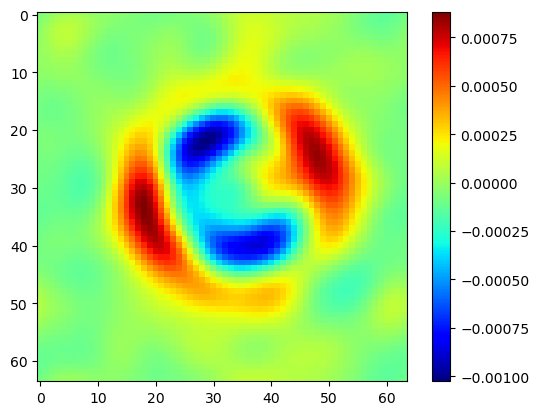

In [32]:
plt.imshow((pred-arr_q)[51*30, 0, 0, ..., 0].cpu().numpy(), cmap='jet')
plt.colorbar()
plt.show()

End of file